### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №3 - Дерево решений


**Общая информация**

**Срок сдачи:** 3 мая 2021, 08:30   
**Штраф за опоздание:** -2 балла после 08:30 03 мая, -4 балла после 08:30 10 мая, -6 баллов после 08:30 17 мая, -8 баллов после 08:30 24 мая.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0221, Задание 3] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Реализуем дерево решений (3 балла)

Допишите недостающие части дерева решений. Ваша реализация дерева должна работать по точности не хуже DecisionTreeClassifier из sklearn.
Внимание: если Вас не устраивает предложенная структура хранения дерева, Вы без потери баллов можете сделать свой класс DecisionTreeClassifier, в котором сами полностью воспроизведете алгоритм дерева решений. Обязательно в нем иметь только функции fit, predict

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier


In [108]:
class MyDecisionTreeClassifier:
    NON_LEAF_TYPE = 0
    LEAF_TYPE = 1

    def __init__(self, min_samples_split=2, max_depth=5, criterion='gini'):
        """
        criterion -- критерий расщепления. необходимо релизовать три:
        Ошибка классификации, Индекс Джини, Энтропийный критерий
        max_depth -- максимальная глубина дерева
        min_samples_split -- минимальное число объектов в листе, чтобы сделать новый сплит
        """
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.num_class = -1
        # Для последнего задания
        self.feature_importances_ = None
        self.criterion = criterion
        # Структура, которая описывает дерево
        # Представляет словарь, где для  node_id (айдишник узла дерева) храним
        # (тип_узла, айдишник признака сплита, порог сплита) если тип NON_LEAF_TYPE
        # (тип_узла, предсказание класса, вероятность класса) если тип LEAF_TYPE
        # Подразумевается, что у каждого node_id в дереве слева 
        # узел с айди 2 * node_id + 1, а справа 2 * node_id + 2
        self.tree = dict()

    def __div_samples(self, x, y, feature_id, threshold):
        """
        Разделяет объекты на 2 множества
        x -- матрица объектов
        y -- вектор ответов
        feature_id -- айдишник признака, по которому делаем сплит
        threshold -- порог, по которому делаем сплит
        """
        left_mask = x[:, feature_id] > threshold
        right_mask = ~left_mask
        return x[left_mask], x[right_mask], y[left_mask], y[right_mask]

    
    def __find_threshold(self, x, y):
        """
        Находим оптимальный признак и порог для сплита
        Здесь используемые разные impurity в зависимости от self.criterion
        """
        feature_amount = x.shape[1]
        features_info = np.zeros(feature_amount)
        thresholds = np.zeros(feature_amount)
        y_uniq = np.unique(y, return_counts = True)
        p_v = y_uniq[1]/np.sum(y_uniq[1])
        for i in range(feature_amount):
            unique_vals = np.unique(x[:, i])
            #func = np.vectorize(self.__find_best_th,excluded=['x','y'])
            #Q = func(unique_vals,i,x,y)
            Q = np.zeros(unique_vals.shape)
            for j, th in enumerate(unique_vals):
                x_left, x_right, y_left, y_right = self.__div_samples(x, y, i, th)
                if x_left.shape[0] == 0 or x_right.shape[0] == 0:
                    Q[j] = 0
                else:    
                    y_left_uniq = np.unique(y_left, return_counts = True)
                    y_right_uniq = np.unique(y_right, return_counts = True)
                    p_v_l = y_left_uniq[1]/np.sum(y_left_uniq[1])
                    p_v_r = y_right_uniq[1]/np.sum(y_right_uniq[1])
                    if self.criterion == 'classification_error':
                        F_e = 1 - np.max(p_v)
                        F_e_left = 1 - np.max(p_v_l)
                        F_e_right = 1 - np.max(p_v_r)
                    elif self.criterion == 'gini':
                        F_e = 1 - np.sum(p_v ** 2)
                        F_e_left = 1 - np.sum(p_v_l ** 2)
                        F_e_right = 1 - np.sum(p_v_r ** 2)
                    elif self.criterion == 'entropy':
                        F_e = - np.sum(p_v * np.log(p_v))
                        F_e_left = - np.sum(p_v * np.log(p_v))
                        F_e_right = - np.sum(p_v * np.log(p_v))
                    else:
                        raise KeyError; 
                    Q[j] = F_e - y_left.shape[0]/y.shape[0] * F_e_left - y_right.shape[0]/y.shape[0] * F_e_right    
            features_info[i] = np.max(Q)
            thresholds[i] = unique_vals[np.argmax(Q)]
        feature_id = np.argmax(features_info)
        best_th = thresholds[feature_id]
        self.feature_importances_[feature_id] += features_info[feature_id]
        return feature_id, best_th

    def __fit_node(self, x, y, node_id, depth):
        """
        Делаем новый узел в дереве
        Решаем, терминальный он или нет
        Если нет, то строим левый узел  с айди 2 * node_id + 1
        И правый узел с  айди 2 * node_id + 2
        """
        if depth < self.max_depth and x.shape[0] >= self.min_samples_split:
            feature_id, th = self.__find_threshold(x,y)
            self.tree[node_id] = (self.__class__.NON_LEAF_TYPE, feature_id , th)
            x_left, x_right, y_left, y_right = self.__div_samples(x, y, feature_id, th)
            if (x_left.shape[0] == 0) or (x_right.shape[0] == 0):
                y_uniq = np.unique(y, return_counts = True)
                p_v = y_uniq[1]/np.sum(y_uniq[1])
                top_class = y_uniq[0][np.argmax(p_v)]
                top_probability = np.max(p_v)
                self.tree[node_id] = (self.__class__.LEAF_TYPE, top_class , top_probability)
            else:
                self.__fit_node(x_left,y_left, 2 * node_id + 1, depth + 1)
                self.__fit_node(x_right,y_right, 2 * node_id + 2, depth + 1)
        else:
            y_uniq = np.unique(y, return_counts = True)
            p_v = y_uniq[1]/np.sum(y_uniq[1])
            top_class = y_uniq[0][np.argmax(p_v)]
            top_probability = np.max(p_v)
            self.tree[node_id] = (self.__class__.LEAF_TYPE, top_class , top_probability)
        
    
    def fit(self, x, y):
        """
        Рекурсивно строим дерево решений
        Начинаем с корня node_id 0
        """
        self.feature_importances_ = dict()
        self.num_class = np.unique(y).size
        for i in range(x.shape[1]):
            self.feature_importances_[i] = 0 
        self.__fit_node(x, y, 0, 0) 

    def __predict_class(self, x, node_id):
        """
        Рекурсивно обходим дерево по всем узлам,
        пока не дойдем до терминального
        """
        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold = node
            if x[feature_id] > threshold:
                return self.__predict_class(x, 2 * node_id + 1)
            else:
                return self.__predict_class(x, 2 * node_id + 2)
        else:
            return node[1]
        
    def predict(self, X):
        """
        Вызывает predict для всех объектов из матрицы X
        """
        return np.array([self.__predict_class(x, 0) for x in X])
    
    def fit_predict(self, x_train, y_train, predicted_x):
        self.fit(x_train, y_train)
        return self.predict(predicted_x)
    
    def get_feature_importance(self):
        return self.feature_importances_

In [113]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2)
clf = DecisionTreeClassifier(min_samples_split=2)

In [114]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [115]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [116]:
a1 = accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)
a2 = accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)
print(a1)
print(a2)

0.8888888888888888
0.8888888888888888


## Ускоряем дерево решений (2 балла)
Добиться скорости работы на fit не медленнее чем в 10 раз sklearn на данных wine. 
Для этого используем numpy.

In [7]:
%time clf.fit(X_train, y_train)

Wall time: 998 µs


DecisionTreeClassifier()

In [8]:
%time my_clf.fit(X_train, y_train)

Wall time: 615 ms


## Боевое применение (3 балла)

На практике Вы познакомились с датасетом Speed Dating Data. В нем каждая пара в быстрых свиданиях характеризуется определенным набором признаков. Задача -- предсказать, произойдет ли матч пары (колонка match). 

Пример работы с датасетом можете найти в практике пункт 2
https://github.com/VVVikulin/ml1.sphere/blob/master/2019-09/lecture_06/pract-trees.ipynb

Данные и описания колонок лежат тут
https://cloud.mail.ru/public/8nHV/p6J7wY1y1/speed-dating-experiment/

Скачайте датасет, обработайте данные, как показано на семинаре или своим собственным способом. Обучите дерево классифкации. В качестве таргета возьмите колонку 'match'. Постарайтесь хорошо обработать признаки, чтобы выбить максимальную точность. Если точность будет близка к случайному гаданию, задание не будет защитано. 


In [9]:
df = pd.read_csv('Speed Dating Data.csv', encoding='latin1')
df

,iid,id,gender,idg,condtn,wave,round,position,positin1,order,...,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
0,1,1.0,0,1,1,1,10,7,NaN,4,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
1,1,1.0,0,1,1,1,10,7,NaN,3,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
2,1,1.0,0,1,1,1,10,7,NaN,10,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
3,1,1.0,0,1,1,1,10,7,NaN,5,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
4,1,1.0,0,1,1,1,10,7,NaN,7,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8373,552,22.0,1,44,2,21,22,14,10.0,5,...,8.0,5.0,7.0,6.0,7.0,9.0,5.0,9.0,5.0,6.0
8374,552,22.0,1,44,2,21,22,13,10.0,4,...,8.0,5.0,7.0,6.0,7.0,9.0,5.0,9.0,5.0,6.0
8375,552,22.0,1,44,2,21,22,19,10.0,10,...,8.0,5.0,7.0,6.0,7.0,9.0,5.0,9.0,5.0,6.0
8376,552,22.0,1,44,2,21,22,3,10.0,16,...,8.0,5.0,7.0,6.0,7.0,9.0,5.0,9.0,5.0,6.0


In [10]:
df.shape

(8378, 195)

In [11]:
df = df.iloc[:, :97]
df.shape

(8378, 97)

In [12]:
df = df.drop(['id'], axis=1)
df = df.drop(['idg'], axis=1)

In [13]:
df = df.drop(['condtn'], axis=1)

In [14]:
#в кач-ве признака юзать не будем
df.wave.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21], dtype=int64)

In [15]:
df = df.drop(['round'], axis=1)

In [16]:
df = df.drop(['position', 'positin1'], axis=1)

In [17]:
df = df.drop(['order'], axis=1)

In [18]:
df = df.drop(['partner'], axis=1)

pid:
partner’s iid number А вот это важно

In [19]:

df = df.drop(['age_o', 'race_o', 'pf_o_att', 
              'pf_o_sin', 'pf_o_int',
              'pf_o_fun', 'pf_o_amb', 'pf_o_sha',
              'dec_o', 'attr_o', 'sinc_o', 'intel_o', 'fun_o',
              'amb_o', 'shar_o', 'like_o', 'prob_o','met_o'], 
             axis=1)

In [20]:
df = df.dropna(subset=['age'])

In [21]:

for i, group in df.groupby('field_cd'):
    print('=' * 10)
    print('Field Code {}'.format(i))
    print(group.field.unique())

Field Code 1.0
['Law' 'law' 'LAW' 'Law and Social Work'
 'Law and English Literature (J.D./Ph.D.)' 'Intellectual Property Law'
 'Law/Business']
Field Code 2.0
['Economics' 'Mathematics' 'Statistics' 'math' 'Mathematics, PhD' 'Stats'
 'math of finance' 'Math']
Field Code 3.0
['Psychology' 'Speech Language Pathology' 'Speech Languahe Pathology'
 'Educational Psychology' 'Organizational Psychology' 'psychology'
 'Communications' 'Sociology' 'psychology and english' 'theory'
 'Health policy' 'Clinical Psychology' 'Sociology and Education'
 'sociology' 'Anthropology/Education' 'speech pathology'
 'Speech Pathology' 'Anthropology' 'School Psychology' 'anthropology'
 'Counseling Psychology' 'African-American Studies/History']
Field Code 4.0
['Medicine' 'Art History/medicine'
 'Sociomedical Sciences- School of Public Health' 'Epidemiology'
 'GS Postbacc PreMed' 'medicine']
Field Code 5.0
['Operations Research' 'Mechanical Engineering' 'Engineering'
 'Electrical Engineering' 'Operations Researc

In [22]:
df.loc[:, 'field_cd'] = df.loc[:, 'field_cd'].fillna(19)

In [23]:
df = df.drop(['field'], axis=1)

In [24]:
#Надо же как-то закодировать field_cd!

In [25]:
from sklearn.preprocessing import OneHotEncoder

e = OneHotEncoder()

In [26]:
x = df["field_cd"].values.reshape(-1,1)
a = e.fit_transform(x).toarray()
a.shape, df.shape

((8283, 19), (8283, 70))

In [27]:
df = pd.concat([df,pd.DataFrame(a,index=df.index)],axis=1)

In [28]:
df = df.drop(['field_cd'], axis=1)

In [29]:
df = df.drop(['undergra'], axis=1)

In [30]:
df.loc[:, 'mn_sat'] = df.loc[:, 'mn_sat'].str.replace(',', '').astype(np.float)

<AxesSubplot:>

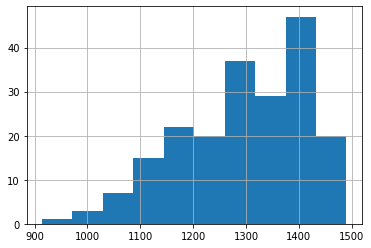

In [31]:
df.drop_duplicates('iid').mn_sat.hist()

In [32]:
df.drop_duplicates('iid').mn_sat.isnull().sum()

342

In [33]:
m = df.drop_duplicates('iid').mn_sat.median()

In [34]:
df['mn_sat'] = df['mn_sat'].fillna(m)

In [35]:

df.loc[:, 'tuition'] = df.loc[:, 'tuition'].str.replace(',', '').astype(np.float)

In [36]:

df.drop_duplicates('iid').tuition.isnull().sum()

310

<AxesSubplot:>

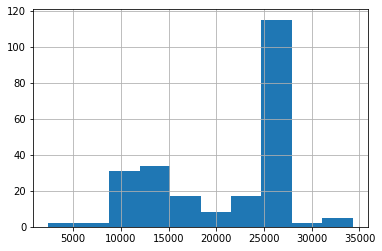

In [37]:
df.drop_duplicates('iid').tuition.hist()

In [38]:
m = df.drop_duplicates('iid').tuition.median()
df['tuition'] = df['tuition'].fillna(m)


race:
Black/African American=1
European/Caucasian-American=2
Latino/Hispanic American=3
Asian/Pacific Islander/Asian-American=4
Native American=5
Other=6

In [39]:
e = OneHotEncoder()
x = df["race"].values.reshape(-1,1)
a = e.fit_transform(x).toarray()
df = pd.concat([df,pd.DataFrame(a,index=df.index)],axis=1)

In [40]:
df.drop_duplicates('iid').imprace.isnull().sum()

1

In [41]:

df.drop_duplicates('iid').imprelig.isnull().sum()

1

In [42]:
df = df.dropna(subset=['imprelig', 'imprace'])

In [43]:
df = df.drop(['from', 'zipcode'], axis=1)

In [44]:
df.loc[:, 'income'] = df.loc[:, 'income'].str.replace(',', '').astype(np.float)

<AxesSubplot:>

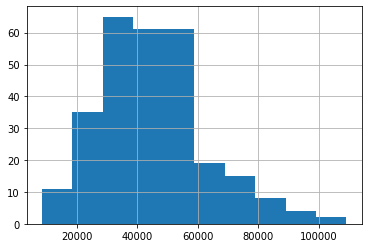

In [45]:
df.drop_duplicates('iid').loc[:, 'income'].hist()

In [46]:
df.drop_duplicates('iid').loc[:, 'income'].isnull().sum()

261

In [47]:
df.loc[:, 'income'] = df.loc[:, 'income'].fillna(-666)

goal:
What is your primary goal in participating in this event? 
Seemed like a fun night out=1
To meet new people=2
To get a date=3
Looking for a serious relationship=4
To say I did it=5
Other=6

date:
In general, how frequently do you go on dates? 
Several times a week=1
Twice a week=2
Once a week=3
Twice a month=4
Once a month=5
Several times a year=6
Almost never=7

go out:
How often do you go out (not necessarily on dates)?
Several times a week=1
Twice a week=2
Once a week=3
Twice a month=4
Once a month=5
Several times a year=6
Almost never=7

In [48]:
e = OneHotEncoder()
x = df["goal"].values.reshape(-1,1)
a = e.fit_transform(x).toarray()
df = pd.concat([df,pd.DataFrame(a,index=df.index)],axis=1)

In [49]:

df = df.dropna(subset=['date'])

In [50]:
e = OneHotEncoder()
x = df["date"].values.reshape(-1,1)
a = e.fit_transform(x).toarray()
df = pd.concat([df,pd.DataFrame(a,index=df.index)],axis=1)

In [51]:
e = OneHotEncoder()
x = df["go_out"].values.reshape(-1,1)
a = e.fit_transform(x).toarray()
df = pd.concat([df,pd.DataFrame(a,index=df.index)],axis=1)

In [52]:

df = df.drop(['goal'], axis=1)
df = df.drop(['date'], axis=1)
df = df.drop(['go_out'], axis=1)

In [53]:
for i, group in df.groupby('career_c'):
    print('=' * 10)
    print('Career Code {}'.format(i))
    print(group.career.unique())

Career Code 1.0
['lawyer/policy work' 'lawyer' 'Law' 'Corporate Lawyer' 'Lawyer'
 'Corporate attorney' 'law' 'Intellectual Property Attorney' 'LAWYER'
 'attorney' 'Lawyer or professional surfer' 'lawyer/gov.position'
 'Law or finance' 'IP Law' 'Academic (Law)' 'Private Equity' 'attorney?'
 'Corporate law' 'tax lawyer' 'Business/Law' 'Assistant District Attorney']
Career Code 2.0
['Academia, Research, Banking, Life' 'academics or journalism' 'Professor'
 'Academic' 'academia' 'teacher' 'industrial scientist'
 'teaching and then...' 'Professor of Media Studies'
 'Education Administration' 'Academic or Research staff'
 'University Professor' 'Research Scientist'
 'research in industry or academia' 'Teacher/Professor'
 'no idea, maybe a professor' 'a research position' 'professor' 'teaching'
 'engineering professional' 'research' 'Neuroscientist/Professor'
 'Education' 'Professor and Government Official'
 'physicist, probably academia' 'college art teacher' 'academic'
 'Research scientist,

In [54]:
df.loc[:, 'career_c'] = df.loc[:, 'career_c'].fillna(18)

In [55]:

df = df.drop(['career'], axis=1)

In [56]:
e = OneHotEncoder()
x = df["career_c"].values.reshape(-1,1)
a = e.fit_transform(x).toarray()
df = pd.concat([df,pd.DataFrame(a,index=df.index)],axis=1)

In [57]:
df = df.drop(['career_c'], axis=1)

In [58]:
df = df.drop(['sports','tvsports','exercise','dining','museums','art','hiking','gaming',
       'clubbing','reading','tv','theater','movies','concerts','music','shopping','yoga'], axis=1)

In [59]:
df = df.drop(['expnum'], axis=1)

In [60]:
feat = ['iid', 'wave', 'attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']

temp = df.drop_duplicates(subset=['iid', 'wave']).loc[:, feat]
temp.loc[:, 'totalsum'] = temp.iloc[:, 2:].sum(axis=1)

In [61]:
idx = ((temp.wave < 6) | (temp.wave > 9)) & (temp.totalsum < 99)
temp.loc[idx, ]

,iid,wave,attr1_1,sinc1_1,intel1_1,fun1_1,amb1_1,shar1_1,totalsum
918,67,3,20.0,15.0,20.0,20.0,5.0,10.0,90.0
1530,105,4,30.0,15.0,20.0,20.0,0.0,5.0,90.0
7221,489,19,20.0,10.0,20.0,20.0,20.0,0.0,90.0
7586,517,21,15.0,20.0,20.0,20.0,5.0,10.0,90.0
7784,526,21,10.0,10.0,30.0,20.0,10.0,15.0,95.0


In [62]:
idx = ((temp.wave >= 6) & (temp.wave <= 9))
temp.loc[idx, ]

,iid,wave,attr1_1,sinc1_1,intel1_1,fun1_1,amb1_1,shar1_1,totalsum
1846,132,6,16.67,16.67,16.67,16.67,16.67,16.67,100.02
1851,133,6,12.77,19.15,17.02,17.02,14.89,19.15,100.00
1856,134,6,6.67,20.00,20.00,17.78,20.00,15.56,100.01
1861,135,6,18.18,22.73,18.18,13.64,13.64,13.64,100.01
1871,137,6,17.39,17.39,15.22,17.39,13.04,19.57,100.00
...,...,...,...,...,...,...,...,...,...
3308,229,9,21.43,16.67,21.43,16.67,11.90,11.90,100.00
3328,230,9,23.81,23.81,23.81,23.81,2.38,2.38,100.00
3348,231,9,18.60,20.93,23.26,23.26,2.33,11.63,100.01
3368,232,9,17.78,17.78,17.78,17.78,13.33,15.56,100.01


In [63]:
df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']].sum(axis=1)

In [64]:
df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']] = \
(df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']].T/df.loc[:, 'temp_totalsum'].T).T * 100

In [65]:

feat = ['iid', 'wave', 'attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']

temp = df.drop_duplicates(subset=['iid', 'wave']).loc[:, feat]
temp.loc[:, 'totalsum'] = temp.iloc[:, 2:].sum(axis=1)

In [66]:
idx = ((temp.wave < 6) | (temp.wave > 9)) & (temp.totalsum < 90) & (temp.totalsum != 0)
temp.loc[idx, ]

,iid,wave,attr2_1,sinc2_1,intel2_1,fun2_1,amb2_1,shar2_1,totalsum
4816,320,12,20.0,10.0,10.0,10.0,20.0,10.0,80.0


In [67]:
idx = ((temp.wave >= 6) & (temp.wave <= 9))
temp.loc[idx, ]

,iid,wave,attr2_1,sinc2_1,intel2_1,fun2_1,amb2_1,shar2_1,totalsum
1846,132,6,22.73,15.91,13.64,15.91,13.64,18.18,100.01
1851,133,6,24.32,16.22,13.51,16.22,10.81,18.92,100.00
1856,134,6,20.51,15.38,12.82,20.51,12.82,17.95,99.99
1861,135,6,18.75,16.67,14.58,18.75,18.75,12.50,100.00
1871,137,6,14.89,17.02,17.02,17.02,14.89,19.15,99.99
...,...,...,...,...,...,...,...,...,...
3308,229,9,15.22,19.57,15.22,17.39,21.74,10.87,100.01
3328,230,9,16.67,16.67,16.67,16.67,16.67,16.67,100.02
3348,231,9,18.18,11.36,15.91,18.18,20.45,15.91,99.99
3368,232,9,19.15,17.02,17.02,17.02,14.89,14.89,99.99


In [68]:
df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']].sum(axis=1)

In [69]:
df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']] = \
(df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']].T/df.loc[:, 'temp_totalsum'].T).T * 100

In [70]:
df = df.drop(['temp_totalsum'], axis=1)

In [71]:
for i in [4, 5]:
    feat = ['attr{}_1'.format(i), 'sinc{}_1'.format(i), 
            'intel{}_1'.format(i), 'fun{}_1'.format(i), 
            'amb{}_1'.format(i), 'shar{}_1'.format(i)]
    
    if i != 4:
        feat.remove('shar{}_1'.format(i))
    
    df = df.drop(feat, axis=1)

In [72]:

df = df.drop(['wave'], axis=1)

In [73]:
df_male = df.query('gender == 1').drop_duplicates(subset=['iid', 'pid'])\
                                 .drop(['gender'], axis=1)\
                                 .dropna()
df_female = df.query('gender == 0').drop_duplicates(subset=['iid'])\
                                   .drop(['gender', 'match', 'int_corr', 'samerace'], axis=1)\
                                   .dropna()
        


In [74]:
df_male

,iid,pid,match,int_corr,samerace,age,mn_sat,tuition,race,imprace,...,8,9,10,11,12,13,14,15,16,17
100,11,1.0,0,0.14,0,27.0,1310.0,25000.0,2.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
101,11,2.0,0,0.29,1,27.0,1310.0,25000.0,2.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
102,11,3.0,0,-0.24,1,27.0,1310.0,25000.0,2.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
103,11,4.0,0,-0.18,1,27.0,1310.0,25000.0,2.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
104,11,5.0,0,-0.43,1,27.0,1310.0,25000.0,2.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8373,552,526.0,0,0.64,0,25.0,1310.0,25000.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8374,552,527.0,0,0.71,0,25.0,1310.0,25000.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8375,552,528.0,0,-0.46,0,25.0,1310.0,25000.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8376,552,529.0,0,0.62,0,25.0,1310.0,25000.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [75]:
df_female.columns = list(map(lambda x: str(x) + '_f', df_female.columns))

In [76]:
df_male.shape, df_female.shape

((4051, 92), (266, 89))

In [77]:
data = pd.merge(df_male, df_female, left_on='pid', right_on='iid_f')
data

,iid,pid,match,int_corr,samerace,age,mn_sat,tuition,race,imprace,...,8_f,9_f,10_f,11_f,12_f,13_f,14_f,15_f,16_f,17_f
0,11,1.0,0,0.14,0,27.0,1310.0,25000.0,2.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,12,1.0,0,0.54,0,22.0,1310.0,25000.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,13,1.0,1,0.16,1,22.0,1310.0,25000.0,4.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,14,1.0,1,0.61,0,23.0,1310.0,25000.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,15,1.0,1,0.21,0,24.0,1310.0,25000.0,3.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3994,548,530.0,0,0.23,0,30.0,1310.0,25000.0,2.0,8.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3995,549,530.0,0,0.29,0,28.0,1310.0,25000.0,2.0,2.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3996,550,530.0,0,-0.20,0,30.0,1310.0,25000.0,2.0,5.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3997,551,530.0,0,-0.32,0,27.0,1400.0,26019.0,1.0,2.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Разбейте датасет на трейн и валидацию. Подберите на валидации оптимальный критерий  информативности. 
Постройте графики зависимости точности на валидации от глубины дерева, от минимального числа объектов для сплита. 
Какой максимальной точности удалось достигнуть?

In [78]:
y = data["match"].values
y

array([0, 0, 1, ..., 0, 0, 0], dtype=int64)

In [79]:
X = data.drop(["match"], axis = 1).values
X.shape

(3999, 180)

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3)

In [82]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [83]:
accuracy_score(clf.predict(X_test), y_test), accuracy_score(my_clf.predict(X_test), y_test)

(0.7508333333333334, 0.8066666666666666)

In [84]:
info_cr = ['gini', 'classification_error', 'entropy']
for x in info_cr:
    my_clf = MyDecisionTreeClassifier(criterion = x)
    my_clf.fit(X_train, y_train)
    print("Info_cr = ", x, ".  Accuracy = ", accuracy_score(my_clf.predict(X_test), y_test))
    

Info_cr =  gini .  Accuracy =  0.8066666666666666
Info_cr =  classification_error .  Accuracy =  0.8291666666666667
Info_cr =  entropy .  Accuracy =  0.8333333333333334


In [85]:
max_depth = [2,3,4,5,6,8,10,12,16]
res = []
for d in max_depth:
    my_clf = MyDecisionTreeClassifier(criterion = 'entropy', max_depth = d)
    my_clf.fit(X_train, y_train)  
    res.append(accuracy_score(my_clf.predict(X_test), y_test))
    
        

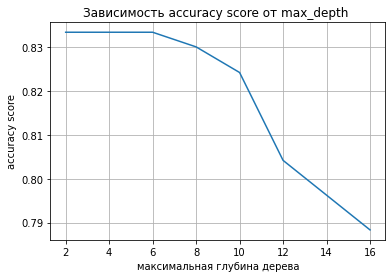

In [86]:
fig, ax = plt.subplots()

ax.plot(max_depth, res)
ax.grid()

ax.set_title('Зависимость accuracy score от max_depth ')

ax.set_xlabel('максимальная глубина дерева')
ax.set_ylabel('accuracy score')

plt.show()

In [98]:
min_samples = [2,5,8,12,16,32,64,80,128]
res = []
for d in min_samples:
    my_clf = MyDecisionTreeClassifier(criterion = 'entropy', min_samples_split = d, max_depth = 10)
    my_clf.fit(X_train, y_train)  
    res.append(accuracy_score(my_clf.predict(X_test), y_test))
    
      

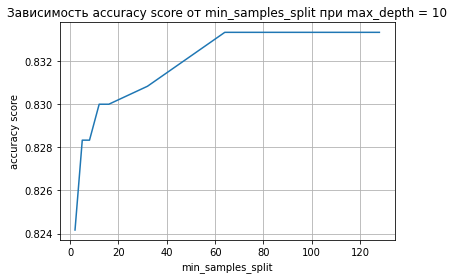

In [99]:
fig, ax = plt.subplots()

ax.plot(min_samples, res)
ax.grid()


ax.set_title('Зависимость accuracy score от min_samples_split при max_depth = 10')

ax.set_xlabel('min_samples_split')
ax.set_ylabel('accuracy score')

plt.show()

In [100]:
np.max(res)

0.8333333333333334

In [101]:
min_samples = [2,5,8,12,16,32,64,80,128]
res = []
for d in min_samples:
    my_clf = MyDecisionTreeClassifier(criterion = 'entropy', min_samples_split = d, max_depth = 2)
    my_clf.fit(X_train, y_train)  
    res.append(accuracy_score(my_clf.predict(X_test), y_test))
    

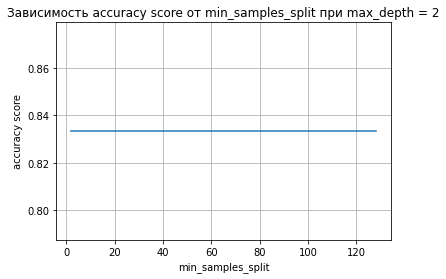

In [102]:
fig, ax = plt.subplots()

ax.plot(min_samples, res)
ax.grid()


ax.set_title('Зависимость accuracy score от min_samples_split при max_depth = 2')

ax.set_xlabel('min_samples_split')
ax.set_ylabel('accuracy score')

plt.show()

In [103]:
np.max(res)

0.8333333333333334

итак, лучшая модель с энтропийным критерием информативности, max_depth = 2 , min_samples_split, например, 2

## Находим самые важные признаки (2 балла)



По построенному дереву  легко понять, какие признаки лучше всего помогли решить задачу. Часто это бывает нужно  не только  для сокращения размерности в данных, но и для лучшего понимания прикладной задачи. Например, Вы хотите понять, какие признаки стоит еще конструировать -- для этого нужно понимать, какие из текущих лучше всего работают в дереве. 

Самый простой метод -- посчитать число сплитов, где использовался данные признак. Это не лучший вариант, так как по признаку который принимает всего 2 значения, но который почти точно разделяет выборку, число сплитов будет очень 1, но при этом признак сам очень хороший. 
В этом задании предлагается для каждого признака считать суммарный gain (в лекции обозначено как Q) при использовании этого признака в сплите. Тогда даже у очень хороших признаков с маленьким число сплитов это значение должно быть довольно высоким.  

Реализовать это довольно просто: создаете словарь номер фичи : суммарный гейн и добавляете в нужную фичу каждый раз, когда используете ее при построении дерева. 

Добавьте функционал, который определяет значения feature importance. Обучите дерево на датасете Speed Dating Data.
Выведите 10 главных фичей по важности.

# Тут специально беру max_depth побольше, так как при маленьком ненулевой гейн только у нескольких фичей , а по заданию надо 10

In [104]:
my_clf = MyDecisionTreeClassifier(criterion = 'entropy', min_samples_split = 2, max_depth = 16)
my_clf.fit(X_train, y_train)
accuracy_score(my_clf.predict(X_test), y_test)


0.7883333333333333

In [105]:
d = my_clf.get_feature_importance()
d

{0: 1.6247420075998775e-14,
 1: 1.5671491881974475e-14,
 2: 8.496675585334401e-15,
 3: 0,
 4: 6.938893903907228e-17,
 5: 0,
 6: 0,
 7: 0,
 8: 0,
 9: 0,
 10: 0,
 11: 1.3877787807814457e-17,
 12: 1.1102230246251565e-16,
 13: 5.551115123125783e-17,
 14: 2.7755575615628914e-17,
 15: 0,
 16: 0,
 17: 0,
 18: 0,
 19: 0,
 20: 0,
 21: 5.551115123125783e-17,
 22: 0,
 23: 0,
 24: 0,
 25: 0,
 26: 0,
 27: 0,
 28: 0,
 29: 0,
 30: 0,
 31: 0,
 32: 0,
 33: 0,
 34: 0,
 35: 0,
 36: 0,
 37: 0,
 38: 0,
 39: 0,
 40: 0,
 41: 0,
 42: 0,
 43: 0,
 44: 0,
 45: 0,
 46: 0,
 47: 0,
 48: 0,
 49: 0,
 50: 0,
 51: 0,
 52: 0,
 53: 0,
 54: 0,
 55: 0,
 56: 0,
 57: 0,
 58: 0,
 59: 0,
 60: 0,
 61: 0,
 62: 0,
 63: 0,
 64: 0,
 65: 0,
 66: 0,
 67: 0,
 68: 5.551115123125783e-17,
 69: 0,
 70: 0,
 71: 0,
 72: 0,
 73: 0,
 74: 0,
 75: 0,
 76: 0,
 77: 0,
 78: 0,
 79: 0,
 80: 0,
 81: 0,
 82: 0,
 83: 0,
 84: 0,
 85: 0,
 86: 0,
 87: 0,
 88: 0,
 89: 0,
 90: 0,
 91: 0,
 92: 0,
 93: 1.942890293094024e-16,
 94: 5.551115123125783e-17,
 95: 

In [106]:
res = list(map(lambda x: x[0], sorted(d.items(), reverse=True, key=lambda element: element[1])))[:10:]
res

[0, 1, 2, 93, 12, 99, 98, 4, 13, 21]

In [107]:
l = data.drop(["match"], axis = 1)
l.columns[res]

Index(['iid', 'pid', 'int_corr', 'age_f', 'attr1_1', 'income_f', 'imprelig_f',
       'age', 'sinc1_1', 'fun2_1'],
      dtype='object')

## Фидбек (бесценно)

* Какие аспекты обучения деревьев решений Вам показались непонятными? Какое место стоит дополнительно объяснить?

# Понятно все, кроме того, как ускорить дерево (((((